In [1]:
import sys
sys.path.append("..")  # Adjusts the path to include the parent directory

# Importing RPS_Basic class from rps_base.py
from rps_simulation.rps_base import RPS_Basic, RPS_Basic_Multirun  
from rps_simulation.learning_curves import exponential_learning, compound_exp_learning
from rps_simulation.forgetting_curves import exponential_forgetting 
from rps_simulation.practice_rate import simple_linear_rate 
from rps_simulation.waiting_times import exponential_waiting_time 

import numpy as np
import matplotlib.pyplot as plt`
import pandas as pd
import seaborn as sns

np.random.seed(10)

# 00. Practice

In [2]:
penguins = sns.load_dataset("penguins")
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


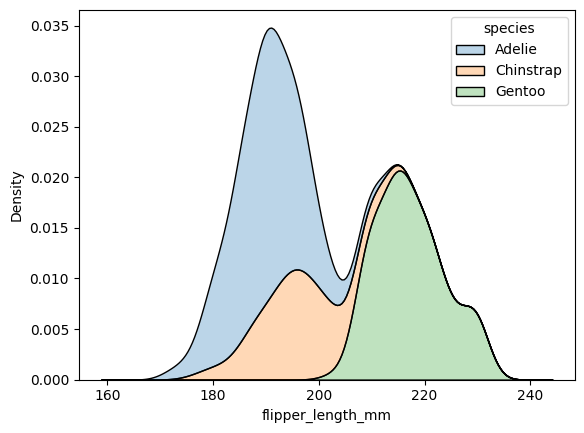

In [3]:
#sns.histplot(data=penguins, x="flipper_length_mm", hue="species", multiple="stack")
#plt.show()
`
sns.kdeplot(data=penguins, x='flipper_length_mm', hue='species', multiple='stack', alpha=0.3)
plt.show()

## 1. Compound Exponential Curve:
### 1.1 Changing Inflection (Matched Area of Impact Function):



In [112]:
comp_exp = compound_exp_learning(alpha=0.15, c=1)
n_sims = 200

c_vals = np.array([1, 2, 4, 6, 8, 10])
#alpha_vals = [0.15 for c in c_vals]
alpha_vals = comp_exp.match_alpha(c_vals) 
s_vals = np.linspace(0,1, 101)

# data:
data_comp_exp = {'c_val': list(np.repeat(c_vals, n_sims)), 'alpha_val': list(np.repeat(alpha_vals, n_sims)),
                 'final_skills': [], 'n_prac': []}
impact_func = [] # list of lists, one for each c_val, corresponds to s_vals
`
# running simulation:
for c1, a1 in zip(c_vals, alpha_vals):
    temp_sims = RPS_Basic_Multirun(learning_func=compound_exp_learning(alpha=a1,c=c1),
                            forgetting_func=exponential_forgetting(forgetting_rate=0.3),
                            practice_rate_func=simple_linear_rate(a=0.2,b=3),
                            waiting_time_dist=exponential_waiting_time,
                            n_sims=n_sims,
                            initial_skill=0.01, initial_practice_rate=1, max_time=100)
    # adding sim data:
    temp_sims.run_multiple_sims()
    data_comp_exp['final_skills'] += temp_sims.final_skills
    data_comp_exp['n_prac'] += temp_sims.practice_events_counts

    # adding impact function data:
    impact_func.append(compound_exp_learning(alpha=a1, c=c1).impact_func(s_vals))
    

# Making Dataframe from sim results
df_comp_exp = pd.DataFrame(data_comp_exp)


In [113]:
len(impact_func[0])

101

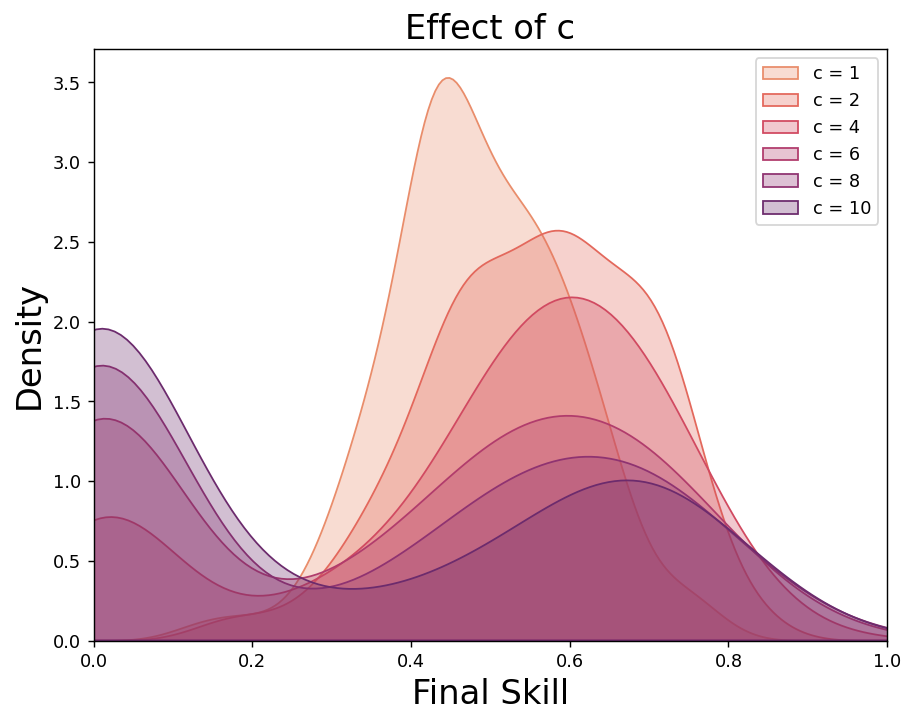

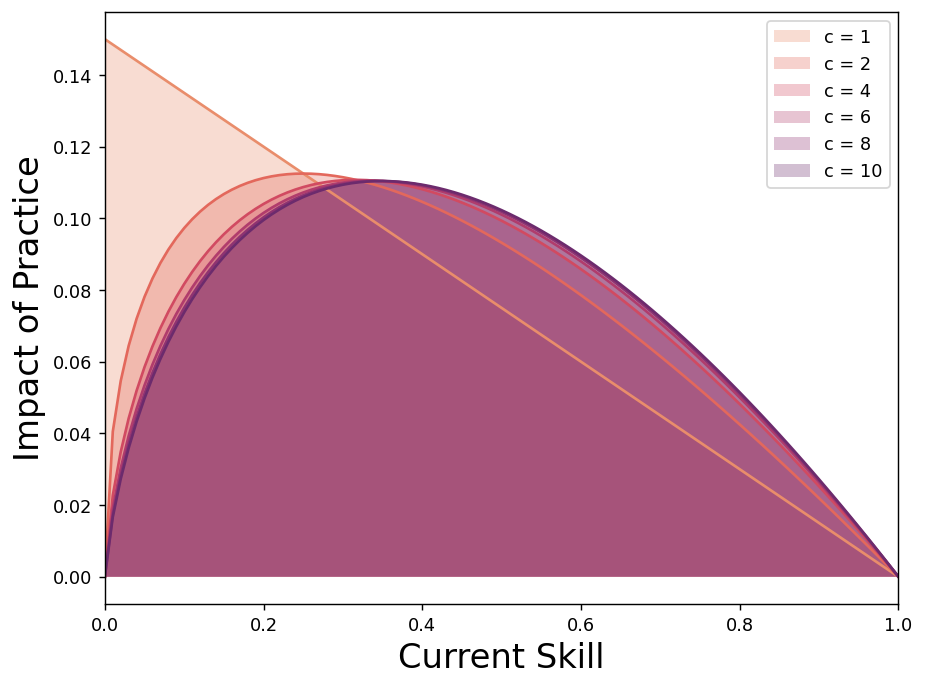

In [118]:
# seaborn templates:
col_pal = sns.color_palette("flare")

########################
## HISTOGRAM: FINAL SKILL
########################

# Set up the matplotlib figure
plt.figure(figsize=(8, 6), dpi=128)
# Plot each dataset with a KDE
for i in range(len(c_vals)):
    with sns.color_palette("flare"):
        sns.kdeplot(df_comp_exp['final_skills'][n_sims*i:n_sims*(i+1)], alpha=0.3, 
                    fill=True, label='c = ' + str(c_vals[i]))
# Adding labels and title
plt.title('Effect of c', fontsize=19)
plt.xlim([0,1])
#plt.ylim([0,10])
plt.xlabel('Final Skill', fontsize=19)
plt.ylabel('Density', fontsize=19)
plt.legend() # Show the legend
plt.savefig('../plots/compound_exp_infl.png', dpi=512)
# Display the plot
plt.show()


########################
## IMPACT FUNCTION PLOT
########################

# Set up the matplotlib figure
plt.figure(figsize=(8, 6), dpi=128)
# Plot each dataset with a KDE
for i in range(len(c_vals)):
    with sns.color_palette("flare"):
        #sns.lineplot(x=s_vals, y=impact_func[i], alpha=1, label='c = '+str(c_vals[i]))
        sns.lineplot(x=s_vals, y=impact_func[i], alpha=1)
        plt.fill_between(s_vals, impact_func[i], alpha=0.3, label='c = '+str(c_vals[i]))

        
# Adding labels and title
#plt.title('', fontsize=19)
plt.xlim([0,1])
plt.xlabel('Current Skill', fontsize=19)
plt.ylabel('Impact of Practice', fontsize=19)
plt.legend() # Show the legend
plt.savefig('../plots/compound_exp_impact.png', dpi=512)
# Display the plot
plt.show()





In [95]:
col_pal.as_hex()

['#e98d6b', '#e3685c', '#d14a61', '#b13c6c', '#8f3371', '#6c2b6d']

## 2. Richard's Curves: